<a href="https://colab.research.google.com/github/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando TensorFlow e checando se a GPU responde a ele

In [343]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.10.1
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [344]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid


In [345]:
# Definir diretórios base
base_dir = 'C:/Users/mathe/Desktop/facul/database-tcc/ImageNet100k'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [346]:
# Pegar os diretórios das imagens de treino, teste e validação e separar em batches de 32, e redimensionalizar as imagens para 256x256
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=32, class_mode=None)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(256, 256), batch_size=32, class_mode=None)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=32, class_mode=None)

Found 70000 images belonging to 1 classes.
Found 20000 images belonging to 1 classes.
Found 10000 images belonging to 1 classes.


In [347]:
# Verificar se as imagens estão no tamanho correto
assert train_generator.image_shape == val_generator.image_shape == test_generator.image_shape == (256, 256, 3)

(32, 256, 256, 3)


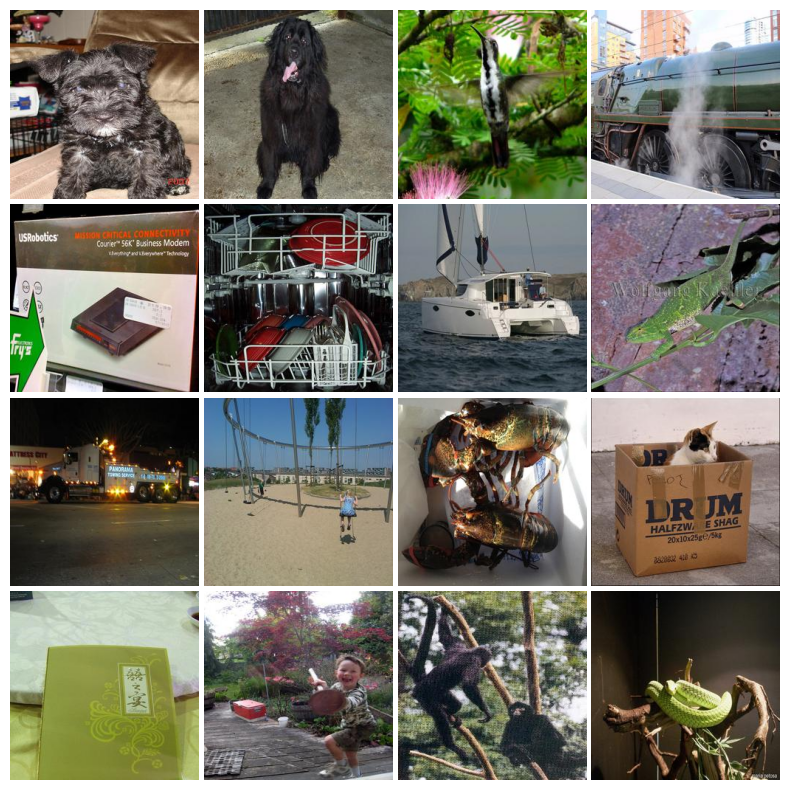

In [348]:
# Dá exemplo de imagens, para vermos se está tudo correto
batch = next(train_generator)
print(batch.shape)

# Plotar imagens
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
for ax, img in zip(grid, batch):
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [349]:
# Vamos agora utilizar essa imagens para treinar um modelo de inpainting, que vai tentar prever o buraco da imagem
# Para isso precisamos que além dessas imagens, tenhamos uma versão delas com buracos desenhados, para que o modelo 
# possa aprender a preencher esses buracos

# Vamos criar uma função que vai pegar uma imagem e desenhar um buraco nela, mas deve ser um buraco de formato e tamanho aleatório
# podendo ser até mais de um buraco, linha, curva ou qualquer outra coisa. Podemos usar funções do OpenCV para isso.

# Função para desenhar um buraco na imagem e retornar a imagem original com uma mascara preta.

import random

def random_mask(img, max_shapes=5):
    """
    Aplica uma máscara aleatória à imagem.
    
    Parâmetros:
    - img: imagem de entrada de tamanho 256x256x3
    - max_shapes: número máximo de formas aleatórias na máscara
    
    Retorna:
    - Imagem com regiões aleatórias faltantes
    """
    h, w, _ = img.shape
    mask = np.ones((h, w), np.uint8) * 255

    for _ in range(random.randint(1, max_shapes)):
        # Escolha aleatoriamente entre criar um polígono, linha ou curva
        shape_type = random.choice(['polygon', 'line', 'curve'])

        if shape_type == 'polygon':
            # Crie um polígono irregular
            vertices = np.array([[
                (random.randint(0, w), random.randint(0, h)) for _ in range(random.randint(3, 10))
            ]], dtype=np.int32)
            cv2.fillPoly(mask, vertices, 0)

        elif shape_type == 'line':
            # Crie uma linha aleatória
            pt1 = (random.randint(0, w), random.randint(0, h))
            pt2 = (random.randint(0, w), random.randint(0, h))
            cv2.line(mask, pt1, pt2, 0, thickness=random.randint(1, 5))

        elif shape_type == 'curve':
            # Crie uma curva (usando polígonos com poucos vértices)
            vertices = np.array([[
                (random.randint(0, w), random.randint(0, h)) for _ in range(random.randint(2, 4))
            ]], dtype=np.int32)
            cv2.polylines(mask, vertices, isClosed=False, color=0, thickness=random.randint(1, 5))

    # Aplica a máscara à imagem
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img


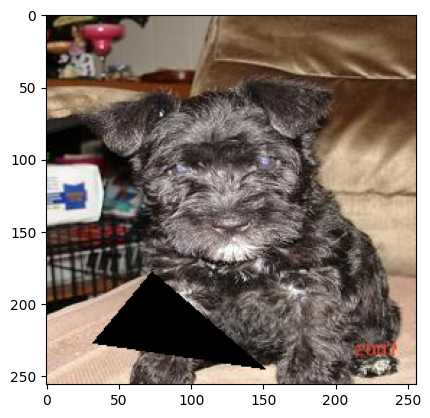

In [350]:
# testa a funcao
img = batch[0]
masked_img = random_mask(img)
plt.imshow(masked_img)

In [351]:
# Queria criar uma classe createAugmentation agora que usasse a funcao de criação de mascaras para em tempo real criar as imagens
# com buracos. 

# Vamos criar uma classe que vai pegar as imagens do gerador e aplicar a função de criação de buracos nelas, para que possamos
# treinar o modelo com as imagens com buracos.

## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

## Seguindo a referência acima, criamos uma classe para gerar os dados de treino e teste, é um gerador de dados que além de tudo 
## aplica uma máscara aleatória nas imagens de treino, para que a rede aprenda a reconstruir a imagem original a partir da máscara.

class createAugment(keras.utils.Sequence):
    """
    Classe dedicada para data Augmentation, em especial para o problema de inpainting, criando máscaras.
    """
    def __init__(self, generator, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True):
        self.generator = generator
        self.batch_size = batch_size 
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        self.on_epoch_end() # Inicializa os índices assim que o objeto é criado

    def on_epoch_end(self) -> None:
        """
        Inicializa ou re-inicializa os indexes após cada época, de preferencia com shuffle = True para o modelo desempenhar de forma robusta.
        """
        self.indexes = np.arange(len(self.generator))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self) -> int:
        """
        Retorna o número de batches por época
        """
        return len(self.generator)

    def __getitem__(self, index) -> tuple:
        """
        É passado um batch de índices para o gerador de dados, que retorna um batch de dados gerados a partir dos índices passados.
        """
        X_batch_original = self.generator[index]
        return self.__data_generation(X_batch_original)

    def __data_generation(self, X_batch_original) -> tuple:
        """ 
        Função que gera um batch de dados para treinamento a partir de um batch de índices. Os dados retornados são um batch de imagens
        mascaradas e um batch de imagens originais, para que o erro seja calculado a partir da imagem reconstruída.
        """
        X_batch = np.array([random_mask(img) for img in X_batch_original])
        return X_batch, X_batch_original


In [352]:
# Defina sua função random_mask aqui ou importe-a se estiver em outro arquivo

# Instancie sua classe de augmentation
augmented_train_generator = createAugment(train_generator, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True)

# Número de batches a serem testados
num_batches = 10

for i in range(num_batches):
    X_batch, y_batch = augmented_train_generator[i]
    
    for j in range(len(X_batch)):
        diff = np.abs(X_batch[j] - y_batch[j])
        total_diff = np.sum(diff)
        
        if total_diff == 0:
            print(f"Erro: A imagem {j} no batch {i} não foi mascarada!")
        else:
            # Reescala as imagens para o intervalo [0, 255] antes de visualizar
            visual_masked = (X_batch[j] * 255).astype(np.uint8)
            visual_original = (y_batch[j] * 255).astype(np.uint8)

"""         
            # Visualizar a imagem mascarada e a imagem original
            cv2.imshow(f"Masked Image {j}", visual_masked)
            cv2.imshow(f"Original Image {j}", visual_original)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
"""
# dei Keyboard interrupt mas testado e funcionando!!!! 

'         \n            # Visualizar a imagem mascarada e a imagem original\n            cv2.imshow(f"Masked Image {j}", visual_masked)\n            cv2.imshow(f"Original Image {j}", visual_original)\n            cv2.waitKey(0)\n            cv2.destroyAllWindows()\n'

## Autoencoder-Decoder Model

In [353]:
# Vídeo sobre a métrica do coeficiente de dice que vamos usar: https://www.youtube.com/watch?v=AZr64OxshLo
# Essa métrica é basicamente uma medida de o quanto essa imagem se parece com a original, ou seja, o quanto a imagem reconstruída
# se parece com a imagem original.
# Quanto mais próximo de 1, melhor.

def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [354]:
class inpaintingModel:
  '''
  Fazendo uma UNET para o problema de inpainting. 
  '''
  def prepare_model(self, input_size=(256,256,3)):
    inputs = keras.layers.Input(input_size)

    conv0, pool0 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', inputs)  # Adicionado
    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', pool0) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    conv9, up10 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', up9, conv0)  # Adicionado
    
    conv10 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', up10, False)  # Modificado
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv10)

    return keras.models.Model(inputs=[inputs], outputs=[outputs]) 

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [355]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

# é a figura do modelo mas n ta rodando pq precisa baixar uma dependencia
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [356]:
# Criando callback para salvar os pesos do modelo no melhor ponto de validação e para parar o treinamento caso o modelo não melhore.

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_loss', mode='min')


In [357]:
# Criando callback para salvar as imagens a cada 10 épocas, para ver como nosso modelo ta evoluindo.

from keras.callbacks import Callback

class SaveInpaintingResults(Callback):
    def __init__(self, test_data, save_dir, interval=10):
        super().__init__()
        self.test_data = test_data
        self.save_dir = save_dir
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            # Pegue um batch de dados de teste
            X_test, _ = next(self.test_data)
            
            # Faça a previsão usando o modelo atual
            predicted = self.model.predict(X_test)
            
            # Salve as imagens previstas em um diretório
            epoch_dir = os.path.join(self.save_dir, f'epoch_{epoch + 1}')
            os.makedirs(epoch_dir, exist_ok=True)
            
            for i, img in enumerate(predicted):
                save_path = os.path.join(epoch_dir, f'image_{i}.png')
                cv2.imwrite(save_path, img * 255)

# instanciando o callback
save_results = SaveInpaintingResults(test_generator, 'C:/Users/mathe/Desktop/facul/Projeto-Final/training-results', 10)

In [358]:
# recomendação do gpt para arrumar bug de callback
tf.config.experimental_run_functions_eagerly(True)

# Train

In [360]:
_ = model.fit(augmented_train_generator, 
          workers = 1,
          use_multiprocessing = False,
          validation_data=test_generator, 
          epochs=20, 
          steps_per_epoch=len(train_generator),
          validation_steps=len(test_generator),
          callbacks=[checkpoint])

Epoch 1/20
2188/2188 [==============================] - 1305s 597ms/step - loss: 0.0214 - dice_coef: 0.6085 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 2/20
2188/2188 [==============================] - 1307s 597ms/step - loss: 0.0205 - dice_coef: 0.6090 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 3/20
2188/2188 [==============================] - 1317s 602ms/step - loss: 0.0202 - dice_coef: 0.6090 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 4/20
2188/2188 [==============================] - 1279s 585ms/step - loss: 0.0201 - dice_coef: 0.6091 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 5/20
2188/2188 [==============================] - 1271s 581ms/step - loss: 0.0200 - dice_coef: 0.6091 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 6/20
2188/2188 [==============================] - 1271s 581ms/step - loss: 0.0198 - dice_coef: 0.6092 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 7/20
2188/2188 [========================

1/1 [==============================] - 1s 884ms/step


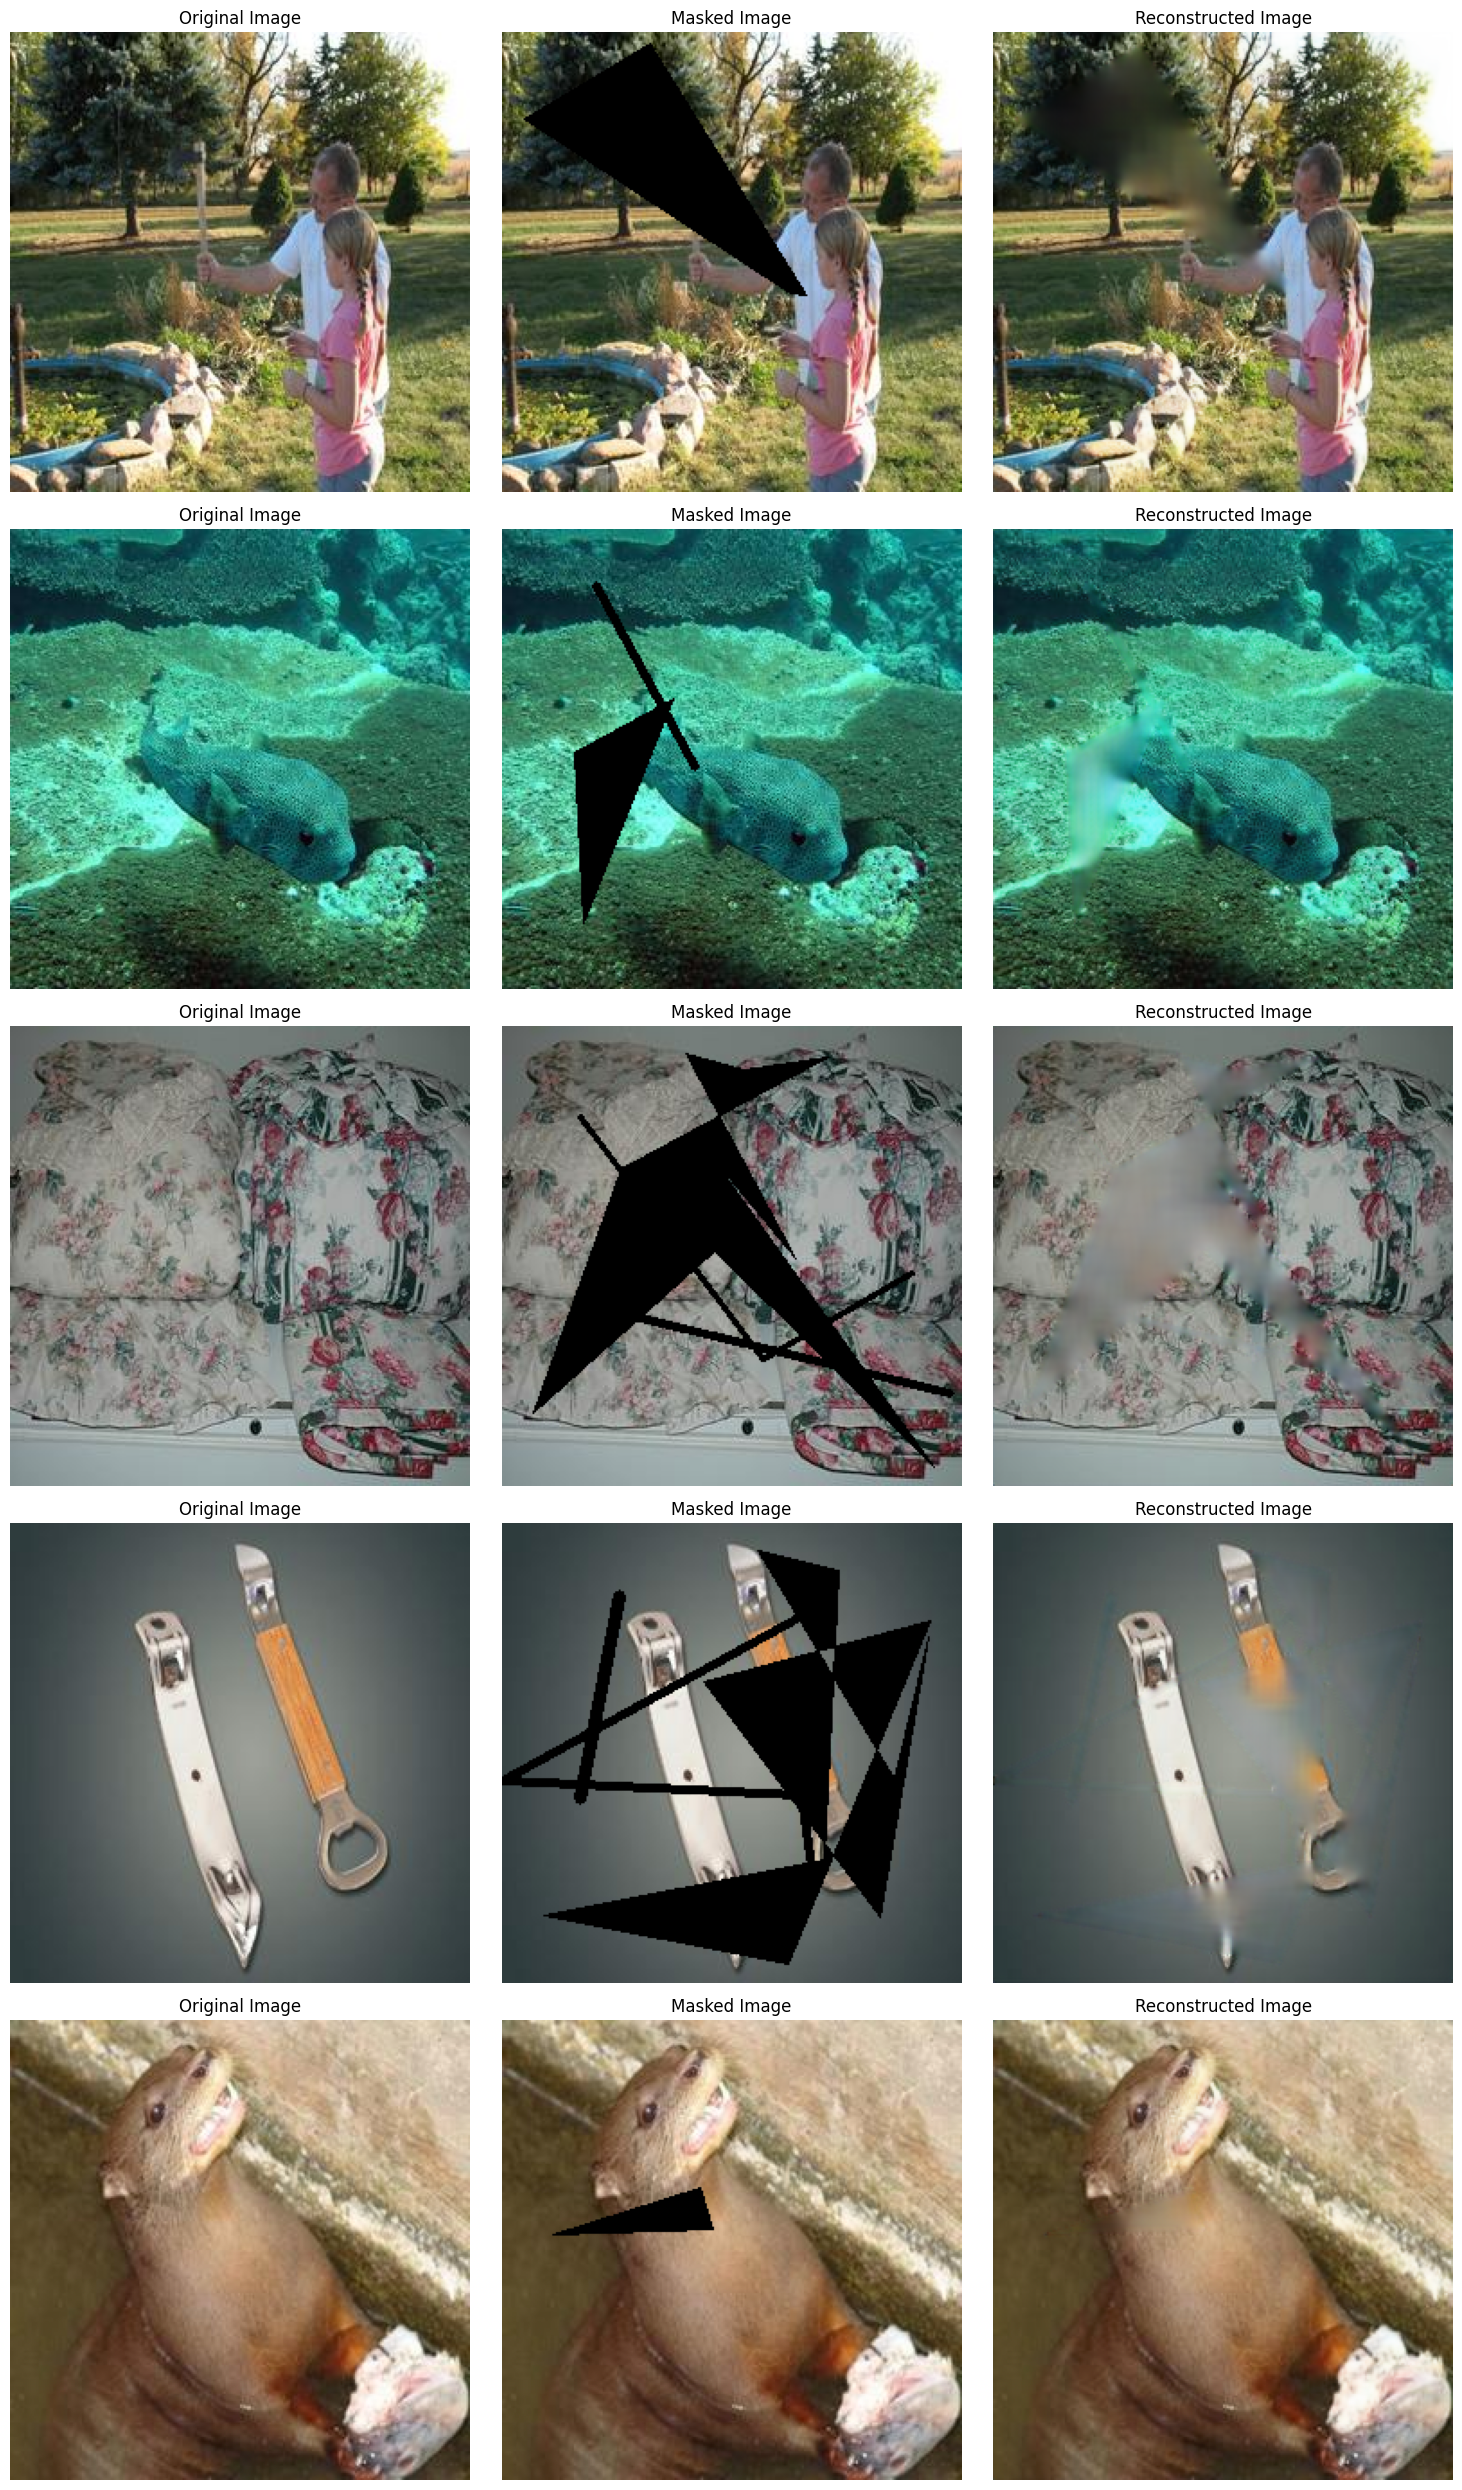

In [366]:
import matplotlib.pyplot as plt

def plot_results(model, test_generator, num_samples=5):
    """
    Plota imagens originais, imagens mascaradas e imagens reconstruídas.
    
    Parâmetros:
    - model: Modelo treinado.
    - test_generator: Gerador de dados de teste.
    - num_samples: Número de amostras a serem plotadas.
    """
    
    # Pegar um batch de imagens do test_generator
    X_batch = test_generator.next()
    
    # Criar máscaras para as imagens
    X_masked = np.array([random_mask(img) for img in X_batch])
    
    # Usar o modelo para prever as imagens reconstruídas
    X_pred = model.predict(X_masked)
    
    # Plotar as imagens
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        axes[i, 0].imshow(X_batch[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(X_masked[i])
        axes[i, 1].set_title("Masked Image")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(X_pred[i])
        axes[i, 2].set_title("Reconstructed Image")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Chamar a função 
plot_results(model, test_generator)


In [369]:
def save_results(model, test_generator, save_dir, num_samples=100):
    """
    Salva imagens originais, imagens mascaradas e imagens reconstruídas em um diretório especificado.
    
    Parâmetros:
    - model: Modelo treinado.
    - test_generator: Gerador de dados de teste.
    - save_dir: Diretório onde as imagens serão salvas.
    - num_samples: Número de amostras a serem salvas.
    """
    
    # Criar o diretório se ele não existir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    samples_saved = 0
    
    while samples_saved < num_samples:
        # Pegar um batch de imagens do test_generator
        X_batch = test_generator.next()
        batch_size = X_batch.shape[0]
        
        # Criar máscaras para as imagens
        X_masked = np.array([random_mask(img) for img in X_batch])
        
        # Usar o modelo para prever as imagens reconstruídas
        X_pred = model.predict(X_masked)
        
        for i in range(batch_size):
            if samples_saved >= num_samples:
                break
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(X_batch[i])
            axes[0].set_title("Original Image")
            axes[0].axis('off')
            
            axes[1].imshow(X_masked[i])
            axes[1].set_title("Masked Image")
            axes[1].axis('off')
            
            axes[2].imshow(X_pred[i])
            axes[2].set_title("Reconstructed Image")
            axes[2].axis('off')
            
            # Salvar a figura
            filename = os.path.join(save_dir, f"sample_{samples_saved+1}.png")
            plt.tight_layout()
            plt.savefig(filename)
            
            # Fechar a figura para liberar memória
            plt.close(fig)
            
            samples_saved += 1

# Chamar a função 
save_dir = "C:/Users/mathe/Desktop/facul/Projeto-Final/outputs/Inpainting-enconder-decoder-v2"  # Substitua pelo caminho desejado
save_results(model, test_generator, save_dir)


1/1 [==============================] - 1s 974ms/step


In [372]:
# quero fazer testes, caminhos das imagens:
original_path = "C:/Users/mathe/Desktop/facul/Projeto-Final/manual_tests/img1-original.jpg"
masked_path = "C:/Users/mathe/Desktop/facul/Projeto-Final/manual_tests/img1-masked.jpg"
output_path = "C:/Users/mathe/Desktop/facul/Projeto-Final/manual_tests/img1-output.jpg"

In [374]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_custom_image(model, original_path, masked_path, output_path):
    # Carregar imagens
    original_img = load_img(original_path, target_size=(256, 256))
    masked_img = load_img(masked_path, target_size=(256, 256))
    
    # Converter imagens para arrays
    original_array = img_to_array(original_img) / 255.0
    masked_array = img_to_array(masked_img) / 255.0
    
    # Usar o modelo para prever a imagem reconstruída
    predicted_array = model.predict(np.expand_dims(masked_array, axis=0))
    
    # Converter o array previsto de volta para uma imagem
    predicted_img = Image.fromarray((predicted_array[0] * 255).astype(np.uint8))
    
    # Salvar a imagem reconstruída
    predicted_img.save(output_path)
    
    # Exibir as imagens
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(masked_img)
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    
    axes[2].imshow(predicted_img)
    axes[2].set_title("Reconstructed Image")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


# Testar o modelo com a imagem personalizada
test_custom_image(model, original_path, masked_path, output_path)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/mathe/Desktop/facul/Projeto-Final/manual_tests/img1-original.jpg'